# Group 22 Final Report

### Group Members:

Kaiser Ninomiya (41514506)

Patrick Cui (39674692)

Uday Kapoor (21201249)

Viet Ngo (71724082)

## Gender Wage Disparities in the United States: A Comparative Analysis

### Table of Contents

- [Introduction](#Introduction)
- [Preliminary Results](#Preliminary-Results)
    - [Data Wrangling](#Data-Wrangling)
    - [Plotting of Relevant Variables](#Plotting-of-Relevant-Variables)
- [Methods and Results](#Methods-and-Results)
- [References](#References)

# Introduction

The proposed project aims to investigate gender wage disparities in the United States using a dataset containing information on various demographic and employment-related variables. The primary question we seek to answer is whether there is a significant difference in wages between male and female workers. We will focus on the hourly wage as our main variable of interest to compare across the two genders. By analyzing this dataset, we aim to shed light on existing gender wage gaps and assess the potential impact of such disparities.
Our project aims to investigate gender wage disparities in the United States using a dataset containing information on various demographic and employment-related variables. We seek to answer whether there is a significant difference in wages between male and female workers.

# Preliminary Results

## Data Wrangling

In [1]:
library(infer)
library(repr)
library(readr)
library(tidyverse)
library(RColorBrewer)

library(cowplot)
library(datateachr)
library(digest)
library(taxyvr)
library(broom)
library(testthat)
library(infer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ dplyr   1.0.10
✔ tibble  3.1.8      ✔ stringr 1.4.1 
✔ tidyr   1.2.1      ✔ forcats 0.5.2 
✔ purrr   0.3.4      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


The following objects are masked from ‘package:readr’:

    edition_get, local_edition




We have successfully imported and cleaned the dataset, ensuring that the data is in a tidy format for analysis. We have also plotted the raw data, specifically examining the distribution of hourly wages for male and female workers. In the preliminary analysis, we observed that there is a clear difference in the distribution of hourly wages between males and females.

In [2]:
raw_data <- read_csv('https://github.com/AVietCong/stat201-group22-project/raw/main/Gender_Pay_Gap_dataset.csv')
head(raw_data)

Rows: 53790 Columns: 129
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): adj_occ2name
dbl (127): year, serial, numprec, gq, region, statefip, metro, metarea, coun...
lgl   (1): farm

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year,serial,numprec,gq,region,statefip,metro,metarea,county,farm,⋯,foodcare,building,sales,officeadmin,farmer,constructextractinstall,production,transport,sumadj_occ,LEHS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2013,4484,1,1,11,50,1,NA,NA,NA,⋯,0,0,0,0,0,0,0,0,1,1
2013,21761,3,1,21,39,3,2002,NA,NA,⋯,0,0,0,0,0,1,0,0,1,1
2013,7174,4,1,11,44,2,6483,NA,NA,⋯,0,0,0,0,0,0,0,0,1,1
2013,58428,1,1,31,12,3,4901,12009,NA,⋯,0,0,0,0,0,0,0,0,1,1
2013,2894,3,1,11,33,1,NA,NA,NA,⋯,0,0,0,0,0,0,0,1,1,1
2013,56021,1,1,31,12,4,2900,12001,NA,⋯,0,0,0,0,0,1,0,0,1,1


In [3]:
raw_data$occupation <- colnames(raw_data[,106:127])[apply(raw_data[,106:127], 1, which.max)]
head(raw_data)

year,serial,numprec,gq,region,statefip,metro,metarea,county,farm,⋯,building,sales,officeadmin,farmer,constructextractinstall,production,transport,sumadj_occ,LEHS,occupation
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2013,4484,1,1,11,50,1,NA,NA,NA,⋯,0,0,0,0,0,0,0,1,1,healthcare
2013,21761,3,1,21,39,3,2002,NA,NA,⋯,0,0,0,0,1,0,0,1,1,constructextractinstall
2013,7174,4,1,11,44,2,6483,NA,NA,⋯,0,0,0,0,0,0,0,1,1,architect
2013,58428,1,1,31,12,3,4901,12009,NA,⋯,0,0,0,0,0,0,0,1,1,manager
2013,2894,3,1,11,33,1,NA,NA,NA,⋯,0,0,0,0,0,0,1,1,1,transport
2013,56021,1,1,31,12,4,2900,12001,NA,⋯,0,0,0,0,1,0,0,1,1,constructextractinstall


In [4]:
filtered_data <- select(raw_data, sex, race, hrwage, incwage, sch, wkswork1, uhrswork, potexp, occupation) %>%
    mutate(sex = as.factor(sex),
           race = as.factor(race),
           hrwage = as.double(hrwage),
           incwage = as.double(incwage),
           sch = as.double(sch),
           wkswork = as.integer(wkswork1),
           uhrswork = as.integer(uhrswork),
           potexp = as.integer(potexp),
           occupation = as.factor(occupation))
head(filtered_data)

sex,race,hrwage,incwage,sch,wkswork1,uhrswork,potexp,occupation,wkswork
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<int>
1,1,24.91259,57000,14,52,44,42,healthcare,52
1,1,31.00000,62000,13,50,40,40,constructextractinstall,50
1,3,21.63461,45000,12,52,40,26,architect,52
1,1,12.82051,28000,12,52,42,23,manager,52
1,1,21.25000,42500,12,50,40,17,transport,50
1,1,21.87500,35000,11,40,40,18,constructextractinstall,40


We have narrowed down the dataset to focus only on the variables of interest: namely sex, race, hourly wage(hrwage), total income (incwage), schooling years (sch), occupation, weeks worked (wkswork1), and usual hours worked (uhrswork).

In [5]:
pay_data <- filtered_data %>%
    mutate(sex = fct_recode(sex, 'male' = '1', 'female' = '2'),
           race = fct_recode(race, 'White' = '1', 'Black' = '2', 'Hispanic' = '3', 'Other' = '4'),
           education_level = case_when(sch == 0 ~ 'None',
                                       sch < 12 ~ 'Incomplete Schooling', 
                                       sch == 12 ~ 'Highschool',
                                       sch == 13 ~ 'College',
                                       sch == 14 ~ 'Associate Degree',
                                       sch <= 16 ~ 'BA',
                                       sch <= 18 ~ 'Advanced Degree')) %>%
    select(-sch)
head(pay_data)

sex,race,hrwage,incwage,wkswork1,uhrswork,potexp,occupation,wkswork,education_level
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<int>,<chr>
male,White,24.91259,57000,52,44,42,healthcare,52,Associate Degree
male,White,31.00000,62000,50,40,40,constructextractinstall,50,College
male,Hispanic,21.63461,45000,52,40,26,architect,52,Highschool
male,White,12.82051,28000,52,42,23,manager,52,Highschool
male,White,21.25000,42500,50,40,17,transport,50,Highschool
male,White,21.87500,35000,40,40,18,constructextractinstall,40,Incomplete Schooling


Here we reassign the factors be more readable.

In [13]:
print("Count of missing values by column wise")
sapply(pay_data, function(x) sum(is.na(x)))

[1] "Count of missing values by column wise"


sex            race          hrwage         incwage        wkswork1 
              0               0               0               0               0 
       uhrswork          potexp      occupation         wkswork education_level 
              0               0               0               0               0

In [14]:
for (x in list("male", "female")) {
    cat("mean for " , x , ": ", mean(subset(pay_data, sex==x)$hrwage), "\n")
    cat("median for ",x,": ", median(subset(pay_data, sex==x)$hrwage), "\n")
    cat("sd for ",x,": ", sd(subset(pay_data, sex==x)$hrwage), "\n", "\n")
}

mean for  male :  28.84364 
median for  male :  21.63461 
sd for  male :  221.4018 
 
mean for  female :  21.92408 
median for  female :  17.30769 
sd for  female :  23.50221 
 


## Plotting of relevant variables

### Demographics

In [15]:
sex_summary <- pay_data |>
    group_by(sex) |>
    summarise(count = n())
sex_summary

sex,count
<fct>,<int>
male,27225
female,26565


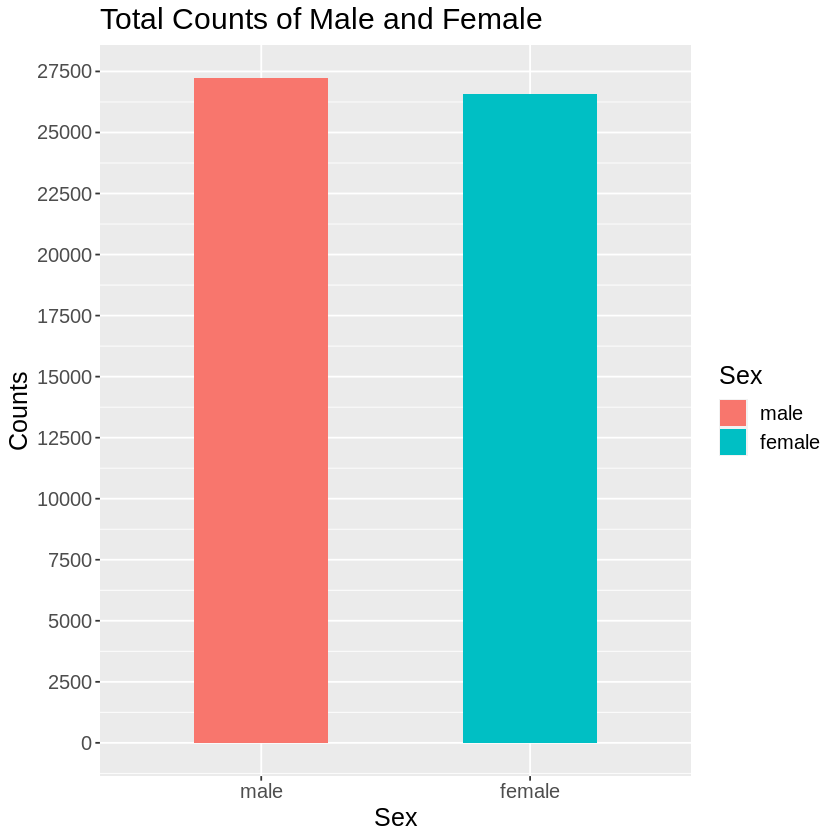

In [16]:
sex_plot <- sex_summary |>
    ggplot(aes(x = sex, y = count, fill = sex)) +
    geom_bar(stat = "identity", width = 0.5) +
    scale_y_continuous(breaks=seq(0, 27500, by = 2500)) +
    labs(x = "Sex", y = "Counts", fill = "Sex") +
    theme(text = element_text(size = 15)) +
    ggtitle("Total Counts of Male and Female")
    
sex_plot

We can see that the number of man and woman in the survey are roughly equal and that the sample size for each group is quite large.

## Hourly Wage 

In [17]:
hrwage_summary <- pay_data %>%
    group_by(sex) %>%
    summarize(mean_wage = mean(hrwage))
hrwage_summary

sex,mean_wage
<fct>,<dbl>
male,28.84364
female,21.92408


Warning message:
“Removed 1186 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 4 rows containing missing values (geom_bar).”


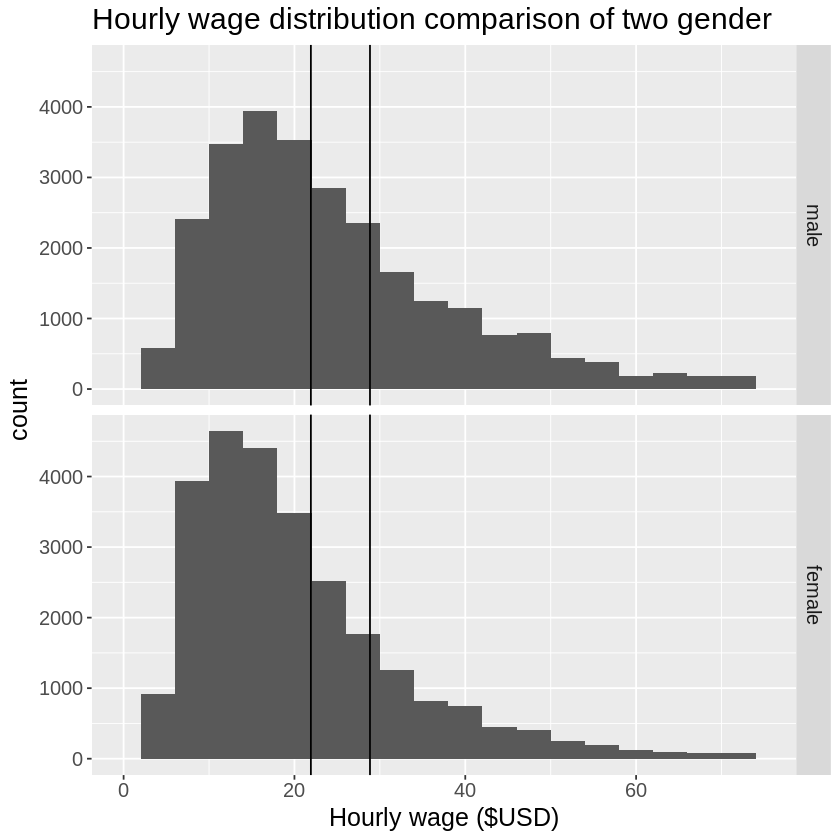

In [27]:
hrwage_plot <- pay_data %>%
  ggplot() +
  geom_histogram(aes(x = hrwage), binwidth = 4) +
  facet_grid(vars(sex)) + 
  xlim(0, 75) + xlab("Hourly wage ($USD)") + 
  ggtitle("Hourly wage distribution comparison of two gender") +
  geom_vline(xintercept = hrwage_summary$mean_wage, show.legend = TRUE) +
  theme(text = element_text(size = 15))
hrwage_plot

# Method and Results

## Trustworthiness of Report

This report aims to ensure its trustworthiness by adhering to the following principles and practices:

**Rigorous Statistical Methods:** By using robust techniques such as hypothesis testing and confidence interval construction, the analysis aims to provide reliable estimates of the wage gap.

**Transparent Data Preprocessing:** The report ensures that the dataset is cleaned and tidied in a manner that minimizes biases and promotes data integrity.

**Reproducibility:** All statistical software code will be included upon setting a seed, enabling others to replicate the results and verify the findings.

**Robustness Checks:** The report incorporates bootstrapping and asymptotic methods to validate the results obtained from traditional hypothesis testing and confidence intervals. 


## Methods

**Data Preprocessing**
- Import the dataset
- Filter the dataset to include only relevant variables and omit any missing data.

**Hypothesis Testing**
- Null hypothesis (H0): There is no significant difference in average hourly wages between male and female workers.
- Alternative hypothesis (H1): There is a significant difference in average hourly wages between male and female workers.
- Two-sample t-test: Difference in the median hourly wages of male and female workers.
- Non-parametric Wilcoxon rank-sum test: to assess wage differences without assuming normality. 

**Bootstrapping and confidence interval**
- Create a bootstrap distribution along with confidence intervals using the original sample, to estimate the variability of our parameter of interest. 
Asymptotics:
- Utilize asymptotic methods, such as the Central Limit Theorem and compare it with bootstrapped estimates for a thorough validation.

**Visualization and Interpretation**
- Present the result of our findings mainly through histogram, and interpret hypothesis tests and CI to assess the significance of the gender wage gap.


In [28]:
data <- pay_data[, c("sex", "hrwage")]
head(data)

sex,hrwage
<fct>,<dbl>
male,24.91259
male,31.00000
male,21.63461
male,12.82051
male,21.25000
male,21.87500


In [29]:
test <- t.test(hrwage ~ sex, data = data)
test


	Welch Two Sample t-test

data:  hrwage by sex
t = 5.1273, df = 27853, p-value = 2.959e-07
alternative hypothesis: true difference in means between group male and group female is not equal to 0
95 percent confidence interval:
 4.274369 9.564756
sample estimates:
  mean in group male mean in group female 
            28.84364             21.92408 


In [30]:
set.seed(2345)
sample <- 
    data %>%
    group_by(sex) %>%
    sample_n(size = case_when(sex == "male" ~ 200,
                              sex == "female" ~ 200), replace = FALSE) %>%
    ungroup()
head(sample)

sex,hrwage
<fct>,<dbl>
male,24.55621
male,44.23077
male,19.23077
male,96.15385
male,72.11539
male,19.11765


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



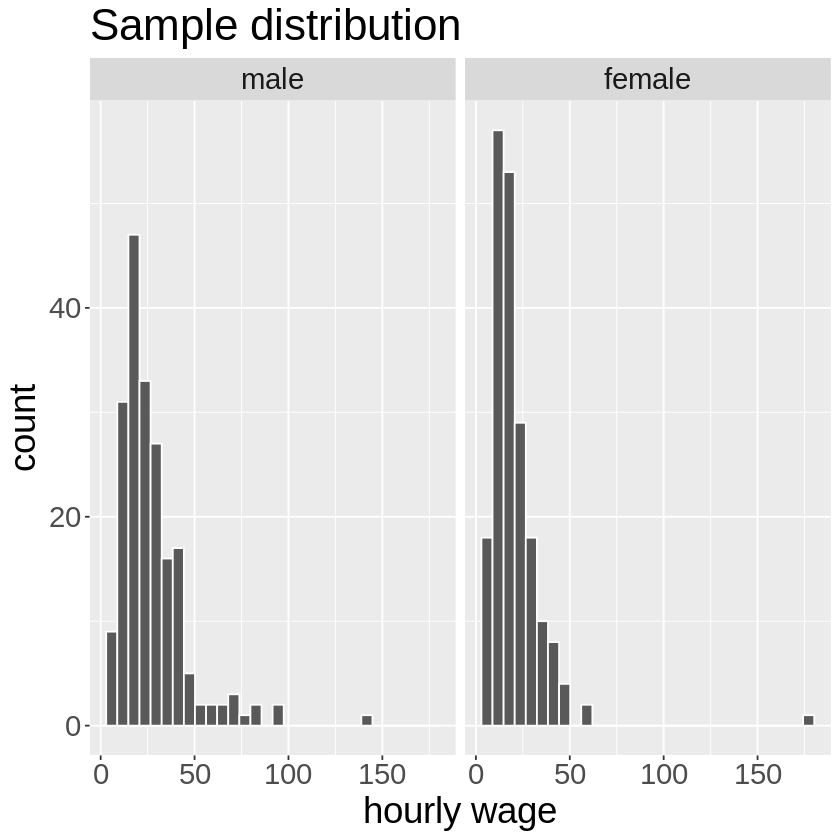

In [31]:
samp_dist_plot <- 
    sample %>% 
    ggplot() + 
    geom_histogram(aes(hrwage), color = 'white') +
    facet_wrap(~ sex) + 
    theme(text = element_text(size = 22)) +
    ggtitle("Sample distribution") + 
    xlab("hourly wage")

samp_dist_plot

In [32]:
sample_summary <- 
    sample %>%
    group_by(sex) %>%
    summarise(sample_mean = mean(hrwage),
             sample_std_error = sd(hrwage)/sqrt(n()))
sample_summary

sex,sample_mean,sample_std_error
<fct>,<dbl>,<dbl>
male,27.38946,1.274007
female,20.32410,1.069211


In [33]:
ci = 0.95

male_mean <- sample_summary$sample_mean[1]
male_var <- sample_summary$sample_std_error[1]^2
female_mean <- sample_summary$sample_mean[2]
female_var <- sample_summary$sample_std_error[2]^2

parking_clt_ci <- 
    tibble(lower_ci = (male_mean - female_mean - qnorm(1- (1-ci)/2) * sqrt(female_var + male_var)),
           upper_ci = (male_mean - female_mean + qnorm(1- (1-ci)/2) * sqrt(female_var + male_var)))

head(parking_clt_ci)

lower_ci,upper_ci
<dbl>,<dbl>
3.805508,10.32522


In [34]:
t_test_summary <- sample %>%
    group_by(sex) %>%
    summarise(
        n = n(),
        x_bar = mean(hrwage),
        sd = sd(hrwage)
    ) %>% 
  pivot_wider(names_from = sex, values_from = c(n, x_bar, sd)) %>% 
  mutate(
    mean_diff = x_bar_male - x_bar_female
  )

t_test_summary <- t_test_summary %>%
mutate(null_std_error = sqrt((sd_male^2 / n_male) + (sd_female^2 / n_female)))

t_test_summary <- 
    t_test_summary %>% 
    mutate(p_value = 2 * pt(mean_diff/null_std_error, df=n_male+n_female-1, lower.tail=FALSE))

t_test_summary

n_male,n_female,x_bar_male,x_bar_female,sd_male,sd_female,mean_diff,null_std_error,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200,200,27.38946,20.3241,18.01718,15.12093,7.065363,1.663222,2.687031e-05


In [35]:
t_test <- 
    tidy(t.test(sample %>% filter(sex == "male") %>% pull(hrwage),
           sample %>% filter(sex == "female") %>% pull(hrwage)))

t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
7.065363,27.38946,20.3241,4.247999,2.70583e-05,386.3729,3.795265,10.33546,Welch Two Sample t-test,two.sided


In [36]:
diff_in_means <- sample |>
    specify(formula = hrwage ~ sex) |>
    generate(reps = 10000, type = "bootstrap") |>
    calculate(stat = "diff in means", order = c("male", "female"))

head(diff_in_means)

replicate,stat
<int>,<dbl>
1,7.908153
2,7.779864
3,7.805138
4,7.629085
5,6.579219
6,10.724013


In [37]:
#Calculating confidence interval for the bootstrap sampling distribution
bootstrap_ci <- diff_in_means |> 
  get_confidence_interval(level = 0.95, type = "percentile")
bootstrap_ci

lower_ci,upper_ci
<dbl>,<dbl>
3.782435,10.34292


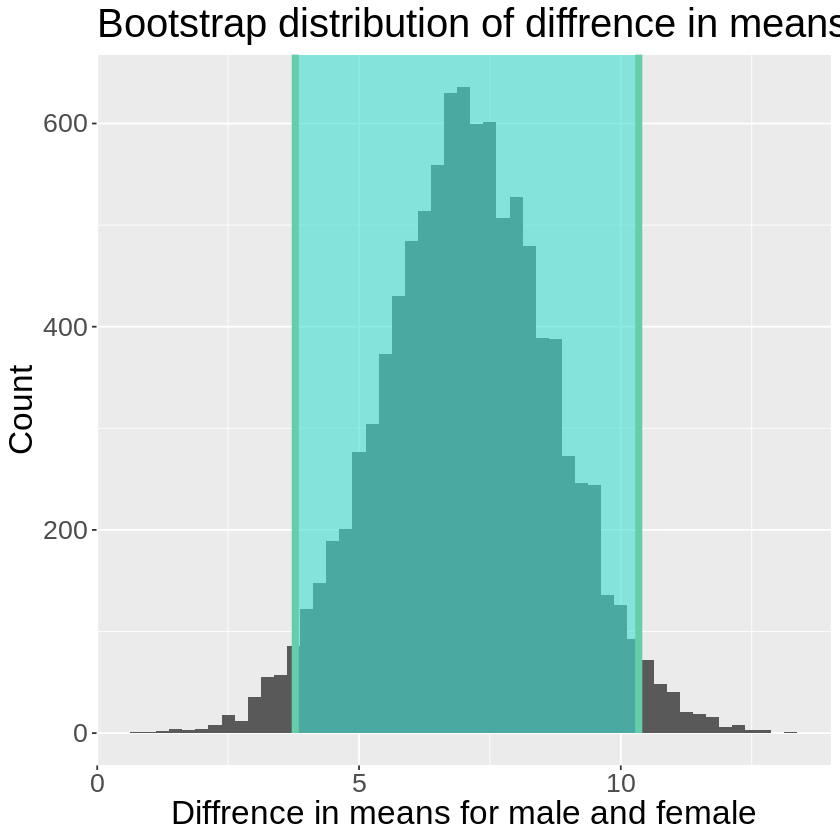

In [38]:
bootstrap_dist <- diff_in_means |>
    ggplot(aes(x = stat)) +
    geom_histogram(binwidth = 0.25) +
    labs(x = "Diffrence in means for male and female", y = "Count") +
    ggtitle("Bootstrap distribution of diffrence in means for male and female") +
    theme(text = element_text(size = 20)) +
    shade_confidence_interval(endpoints = bootstrap_ci)

bootstrap_dist

In [39]:
#creating a null distirbution 
null_diff_means <- sample |>
    specify(formula = hrwage ~ sex) |>
    hypothesize(null = "independence") |>
    generate(reps = 10000, type = "permute") |>
    calculate(stat = "diff in means", order = c("male", "female"))
head(null_diff_means)

replicate,stat
<int>,<dbl>
1,-0.564947264
2,1.310613981
3,-2.158632087
4,-0.009747912
5,-0.037992368
6,1.303442242


In [40]:
#Computing an observed statistic
obs_diff_means <- sample %>% 
  specify(formula = hrwage ~ sex) %>% 
  calculate(stat = "diff in means", order = c("male", "female"))
obs_diff_means

stat
<dbl>
7.065363


In [41]:
#computing p-value
options(digits = 5)

p_value <- null_diff_means %>% 
  get_p_value(obs_stat = obs_diff_means, direction = "both")
p_value
#p-value turned out to be 0.. are we sure?

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


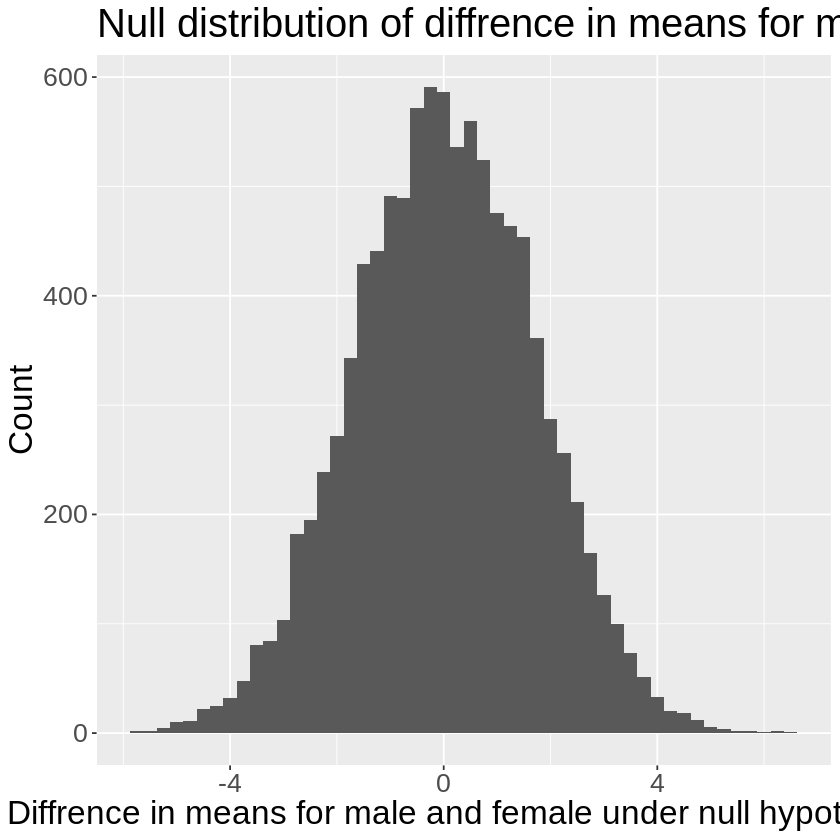

In [42]:
null_distribution <- null_diff_means |>
    ggplot(aes(x = stat)) +
    geom_histogram(binwidth = 0.25) +
    labs(x = "Diffrence in means for male and female under null hypothesis", y = "Count") +
    ggtitle("Null distribution of diffrence in means for male and female") +
    theme(text = element_text(size = 20))
null_distribution
#p-value of 0 could not be visualized..

## Reflecting on how the final report might play out

**Expected Findings:**
We expect to find that female workers earn less median hourly wages than their male counterparts. Additionally, we may anticipate uncovering variations in wage gaps across different racial groups, providing deeper insights into intersectional inequalities.

**Impact of Findings:**
Highlighting the gender wage gap can serve as a call to action for policymakers, employers, and advocates to address this pressing issue. By quantifying the existence of disparities, our study can contribute to the ongoing efforts towards gender equality in the workforce. 

**Future Question:**
Wage Gap in Different Industries: Investigating the wage gap across various industries and occupations could help identify sectors with more significant disparities and guide targeted interventions.

# References

1) Deep B. (2021). Gender Pay Gap Dataset. Kaggle. Retrieved from: https://www.kaggle.com/code/deepbdoshi/gender-pay-gap

2) Blau, F. D., & Kahn, L. M. (2017). The Gender Wage Gap: Extent, Trends, and Explanations. Journal of Economic Literature, 55(3), 789–865. http://www.jstor.org/stable/26303306

3) Pew Research Center. (March 1, 2023). Gender Pay Gap Facts. Pew Research Center. Retrieved from https://www.pewresearch.org/short-reads/2023/03/01/gender-pay-gap-facts/